In [1]:
#1 Verify imports
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

import numpy as np

from sklearn import metrics
from sklearn import svm
from sklearn import tree
from sklearn.datasets import fetch_openml
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

import time

import warnings

#allow plots to appear within the notebook:
%matplotlib inline

print("All imports are good")

All imports are good


In [2]:
#2 Get the data
dataset1 = fetch_openml(name='phoneme') 
X_ds1 = dataset1.data #matrix
y_ds1 = dataset1.target #vector
X_Train_ds1, X_Test_ds1, y_Train_ds1, y_Test_ds1 = \
    train_test_split(X_ds1, y_ds1, test_size=0.2, random_state=0) 

dataset2 = fetch_openml(name='credit-g') 
X_ds2 = dataset2.data #matrix
y_ds2 = dataset2.target #vector
X_Train_ds2, X_Test_ds2, y_Train_ds2, y_Test_ds2 = \
    train_test_split(X_ds2, y_ds2, test_size=0.2, random_state=0) 

#Other global variables:
cv_ds1 = 0
criterion_ds1 = ''
cv_ds2 = 0
criterion_ds2 = ''
current_dataset = ''

print("Data gotten, and other global variables initialized")

Data gotten, and other global variables initialized


In [43]:
#3 Functions
def decisionTree(X_Train, y_Train, cv_max=100):
    cross_val_sizes = range(2,(cv_max+1))
    criteria = ['gini','entropy']
    best_score = 0
    min_score = 1.0
    cv_ds = 0
    criterion_ds = ''
    
    print("Exploring Decision Trees with no pruning...")
    start = time.time()
    for criterion in criteria:
    
        scores = []
        for i in cross_val_sizes:
            dtc = tree.DecisionTreeClassifier(random_state=0, criterion=criterion)
            score = cross_val_score(dtc, X_Train, y_Train, cv=i).mean()
            scores.append(score)
            if score > best_score:
                best_score = score
                cv_ds = i
                criterion_ds=criterion
                print("cv=" + str(i) + ", criterion="+criterion+" : " + str(score))
            if score < min_score:
                min_score = score

        plt.plot(cross_val_sizes, scores, label=criterion)
        plt.xlabel("Cross validation size")
        plt.ylabel("Cross validation score (Performance)")
    
    plt.legend() 
    plt.show()   

    end = time.time()
    
    print("Decision Trees " + current_dataset + " best score = " + str(best_score) + " at cv = " \
          + str(cv_ds) + "(criterion="+criterion_ds+") in "+ getTime(end - start))
    
    dtc = tree.DecisionTreeClassifier(random_state=0, criterion=criterion_ds)
    return cv_ds, criterion_ds, min_score, dtc

def decisionTreePrePruning(X_Train, y_Train, cv_ds, criterion_ds):
    max_depth_sizes = range(2,21)
    scores = []
    best_score = 0
    min_score = 1.0
    max_depth_ds = 0
    
    start = time.time()
    
    print("Exploring Decision Trees with pre-pruning...")
    for md in max_depth_sizes:
        dtc = tree.DecisionTreeClassifier(random_state=0, max_depth=md)
        score = cross_val_score(dtc, X_Train, y_Train, cv=cv_ds).mean()
        scores.append(score)
        if score > best_score:
            best_score = score
            max_depth_ds = md
            print(str(md) + " : " + str(score))
        if score < min_score:
            min_score = score
            
    end = time.time()
    
    print("Decision Trees " + current_dataset + " with pre-pruning best score = " \
        + str(best_score) + " at max_depth = " + str(max_depth_ds) + " in "+ getTime(end - start))
    plt.plot(max_depth_sizes, scores)
    plt.xlabel("Max depth size")
    plt.ylabel("Score")
    
    dtc = tree.DecisionTreeClassifier(random_state=0, max_depth=max_depth_ds)
    
    return min_score, dtc

def decisionTreePostPruning(X_Train, y_Train, cv_ds, criterion_ds):
    ccp_alpha_sizes = range(0,11)
    scores = []
    best_score = 0
    min_score = 1.0
    ccp_alpha_ds = 0

    start = time.time()
    
    print("Exploring Decision Trees with post-pruning...")
    for ccpa in ccp_alpha_sizes:
        dtc = tree.DecisionTreeClassifier(random_state=0, ccp_alpha=ccpa)
        score = cross_val_score(dtc, X_Train, y_Train, cv=cv_ds).mean()
        scores.append(score)
        if score > best_score:
            best_score = score
            ccp_alpha_ds = ccpa
            print(str(ccpa) + " : " + str(score))
        if score < min_score:
            min_score = score
    
    end = time.time()
    
    print("Decision Trees " + current_dataset + " with post-pruning best score = " \
        + str(best_score) + " at ccp_alpha = " + str(ccp_alpha_ds) + " in "+ getTime(end - start))
    plt.plot(ccp_alpha_sizes, scores)
    plt.xlabel("CCP alpha size")
    plt.ylabel("Score")
    
    dtc = tree.DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha_ds)
    
    return min_score, dtc

def neuralNetworks(X_Train, y_Train, cv_ds, is_debug=False):
    solvers = ['lbfgs','sgd','adam'] 
    learning_rates = ['constant', 'adaptive', 'invscaling']
    best_score = 0
    min_score = 1.0
    solver_ds = ''
    learning_rate_ds = ''
    
    print("Exploring Neural Networks...")
    start = time.time()
    
    for my_solver in solvers:
        with warnings.catch_warnings():
            warnings.filterwarnings('error')
            try:
                if my_solver == 'sgd':
                    for learning_rate in learning_rates:
                        mlp = MLPClassifier(solver=my_solver, alpha=100.0, hidden_layer_sizes=(5, 2), \
                                max_iter=y_Train.shape[0], warm_start=True, learning_rate=learning_rate, \
                                random_state=0)
                        score = cross_val_score(mlp, X_Train, y_Train, cv=cv_ds).mean()
                        print(my_solver + " (" + learning_rate + ") : " + str(score))
                        if score > best_score:
                            best_score = score
                            solver_ds = my_solver   
                            learning_rate_ds = learning_rate
                        if score < min_score:
                            min_score = score
                else:
                    mlp = MLPClassifier(solver=my_solver, alpha=100.0, hidden_layer_sizes=(5, 2), \
                        max_iter=y_Train.shape[0], warm_start=True, random_state=0)
                    score = cross_val_score(mlp, X_Train, y_Train, cv=cv_ds).mean()
                    print(my_solver + " : " + str(score))
                    if score > best_score:
                        best_score = score
                        solver_ds = my_solver
                        learning_rate_ds = 'constant'
                    if score < min_score:
                        min_score = score
            except Warning:
                if is_debug:
                    if my_solver == 'sgd':
                        print("Encountered warning where solver = " + my_solver + " and learning_rate = " + learning_rate)
                    else:
                        print("Encountered warning where solver = " + my_solver)
    
    end = time.time()
    
    if solver_ds == 'sgd':
        print("Neural Network " + current_dataset + " with best score = " + str(best_score) + " at solver: " \
              + solver_ds + " ("+learning_rate_ds+") in "+ getTime(end - start))
    else:
        print("Neural Network " + current_dataset + " with best score = " + str(best_score) + " at solver: " \
              + solver_ds + " in "+ getTime(end - start))
    print("")#newline to separate this run from the next
    
    my_alpha = 1e5
    best_score = 0
    alpha_ds = 0.0

    start = time.time()
    
    while my_alpha >= 1e-5:
        with warnings.catch_warnings():
            warnings.filterwarnings('error')
            try:
                mlp = MLPClassifier(solver=solver_ds, alpha=my_alpha, hidden_layer_sizes=(5,2), \
                    max_iter=y_Train.shape[0], warm_start=True, learning_rate=learning_rate_ds, random_state=0)
                score = cross_val_score(mlp, X_Train, y_Train, cv=cv_ds).mean()
                if score > best_score:
                    best_score = score
                    alpha_ds = my_alpha
                    print("alpha " + str(my_alpha) + " : " + str(score))
                if score < min_score:
                    min_score = score
            except Warning:
                if is_debug: print("Caught warning where alpha = " + str(my_alpha))

        my_alpha /= 10 
    
    end = time.time()
    
    print("Neural Network " + current_dataset + " with best score = " + str(best_score) \
          + " at alpha order of magnitude: "+ str(alpha_ds) + " in "+ getTime(end - start))
    print("")#newline to separate this run from the next
    
    scores = []
    As = []
    Bs = []
    my_hidden_layer = (1,1)
    best_score = 0
    hiddle_layer_ds = (0,0)
    activations = ['identity', 'logistic', 'tanh', 'relu']
    activation_ds = ''
    
    start = time.time()
    
    for a in range(1,11):
        for b in range(1,11):
            for activation in activations:
                with warnings.catch_warnings():
                    warnings.filterwarnings('error')
                    try:
                        mlp = MLPClassifier(solver=solver_ds, alpha=alpha_ds, hidden_layer_sizes=my_hidden_layer, \
                            max_iter = y_Train.shape[0], warm_start=True, learning_rate=learning_rate_ds, \
                            activation=activation, random_state=0)
                        score = cross_val_score(mlp, X_Train, y_Train, cv=cv_ds).mean()
                        scores.append(score)
                        As.append(a)
                        Bs.append(b)
                        if score > best_score:
                            best_score = score
                            hiddle_layer_ds = my_hidden_layer
                            activation_ds = activation
                            print(str(my_hidden_layer) + ", activation="+activation+" : " + str(score))
                        if score < min_score:
                            min_score = score
                    except Warning:
                        if is_debug: print("Caught warning where hidden_layer = " + str(my_hidden_layer) \
                                          + " and activation = " + activation)
            my_hidden_layer = (a,b)
        my_hidden_layer = (a,b)
    
    end = time.time()
    
    print("Neural Network " + current_dataset + " with best score = " + str(best_score) + " at hidden layer: " \
          + str(hiddle_layer_ds) + " with activation = " + activation_ds + " in "+ getTime(end - start))
    
    #3d scatter plot:
    fig = plt.figure()
    axes = fig.add_subplot(111, projection='3d')
    axes.scatter(As, Bs, scores)
    
    axes.set_xlabel('As')
    axes.set_ylabel('Bs')
    axes.set_zlabel('Scores')
    plt.show()
    
    mlp = MLPClassifier(solver=solver_ds, alpha=alpha_ds, hidden_layer_sizes=hiddle_layer_ds, \
        max_iter=y_Train.shape[0], warm_start=True, learning_rate=learning_rate_ds, \
        activation=activation_ds, random_state=0)
    
    return min_score, mlp

def boosting(X_Train, y_Train, cv_ds):
    scores = []
    n_range = range(1,101)
    best_score = 0
    min_score = 1.0
    n_estimators_ds = 0
    
    print("Exploring Boosting...")
    start = time.time()
    
    for i in n_range:
        boost = AdaBoostClassifier(n_estimators=i, random_state=0)
        score = cross_val_score(boost, X_Train, y_Train, cv=cv_ds).mean()
        if score > best_score:
            best_score = score
            n_estimators_ds = i
            print("n_estimators = " + str(i) + " : " + str(score))
        if score < min_score:
            min_score = score
        scores.append(score)
    
    end = time.time()
    
    print("Boosting " + current_dataset + " with best score = " + str(best_score) + " at n_estimators: " \
          + str(n_estimators_ds) + " in "+ getTime(end - start))
    
    plt.plot(n_range, scores)
    plt.xlabel("Boosting n_estimators")
    plt.ylabel("Score")
    
    boost = AdaBoostClassifier(n_estimators=n_estimators_ds, random_state=0)
    
    return min_score, boost

def supportVectorMachines(X_Train, y_Train, cv_ds, is_dataset_2=False, is_debug=False):
    SVMs = ['SVC','NuSVC', 'LinearSVC']
    my_SVMs = []
    my_SVMs.append(svm.SVC(random_state=0))
    my_SVMs.append(svm.NuSVC(random_state=0))
    my_SVMs.append(svm.LinearSVC(random_state=0))
    scores = []
    best_score = 0
    min_score = 1.0
    i = 0
    SVM_name_ds = ''

    print("Exploring Support Vector Machines...")
    
    start = time.time()
    
    for mySVM in my_SVMs:
        with warnings.catch_warnings():
            warnings.filterwarnings('error')
            try:
                score = cross_val_score(mySVM, X_Train, y_Train, cv=cv_ds).mean()
                print(SVMs[i] + " score: " + str(score))
                if score > best_score:
                    best_score = score
                    SVM_name_ds = SVMs[i]
                if score < min_score:
                    min_score = score
            except Warning:
                if is_debug: print("Caught warning where SVM = " + SVMs[i])
                score = 0
        scores.append(score)
        i += 1

    plt.plot(SVMs, scores)
    plt.xlabel("Support Vector Machine")
    plt.ylabel("Score")
    
    #SVC is the expected choice
    if SVM_name_ds != 'SVC':
        print("Unexpected optimal SVM type: " + SVM_name_ds + ". Investigate!")
        return None
    
    best_score = 0
    svm_ds = None
    chosen_svm_ds = None

    kernels = ['linear', 'poly', 'rbf', 'sigmoid']
    #leaving out kernel 'precomputed' because it resulted in this error:
    #X should be a square kernel matrix
    kernel_ds = ''
    shrinkings = [True, False]
    shrinking_ds = True
    probabilities = [True, False]
    probability_ds = True
    decision_function_shapes = ['ovo', 'ovr']
    decision_function_shape_ds = ''
    #break_ties doesn't apply because number of classes = 2 (!>2)
    #break_tiess = [True, False]
    #break_ties_ds = True
    gammas = ['scale', 'auto'] 
    gamma_ds = ''
    
    for kernel in kernels:
        if is_debug: print("testing kernel = " + kernel +"...") 
        if is_dataset_2 and kernel == 'linear':
            continue #skip it
        for shrinking in shrinkings:
            if is_debug: print("testing shrinking = " + str(shrinking) + "...") 
            for probability in probabilities:
                if is_debug: print("testing probability = " + str(probability) + "...") 
                for decision_function_shape in decision_function_shapes:
                    if is_debug: print("testing decision_function_shape = " + decision_function_shape + "...") 
                    if kernel == 'rbf' or kernel == 'poly' or kernel == 'sigmoid':
                        for gamma in gammas:
                            if is_debug: print("testing gamma = " + gamma + "...") 
                            if is_dataset_2 and kernel == 'poly' and gamma == 'auto':
                                continue #skip it
                            with warnings.catch_warnings():
                                warnings.filterwarnings('error')
                                try:
                                    svm_ds = svm.SVC(kernel=kernel, shrinking=shrinking, \
                                         probability=probability, \
                                         decision_function_shape=decision_function_shape, \
                                         gamma=gamma, random_state=0)
                                    score = cross_val_score(svm_ds, X_Train, y_Train, cv=cv_ds).mean()
                                    if score > best_score:
                                        chosen_svm_ds = svm_ds
                                        best_score = score
                                        kernel_ds = kernel
                                        shrinking_ds = shrinking
                                        probability_ds = probability
                                        decision_function_shape_ds = decision_function_shape
                                        gamma_ds = gamma
                                        print("kernel: " + kernel + ", shrinking: " + str(shrinking) \
                                              + ", probability: " + str(probability) \
                                              + ", decision_function_shape: " + decision_function_shape \
                                              + ", gamma: " + gamma + ", score: " + str(score))
                                    if score < min_score:
                                        min_score = score
                                except Warning:
                                    if is_debug: print("Caught warning where kernel: " + kernel \
                                                        + ", shrinking: " + str(shrinking) \
                                                        + ", probability: " + str(probability) \
                                                        + ", decision_function_shape: " + decision_function_shape \
                                                        + ", gamma: " + gamma)
                    else: #not searching through gammas
                        with warnings.catch_warnings():
                            warnings.filterwarnings('error')
                            try:
                                svm_ds = svm.SVC(kernel=kernel, shrinking=shrinking, probability=probability, \
                                     decision_function_shape=decision_function_shape, random_state=0)
                                score = cross_val_score(svm_ds, X_Train, y_Train, cv=cv_ds).mean()
                                if score > best_score:
                                    chosen_svm_ds = svm_ds
                                    best_score = score
                                    kernel_ds = kernel
                                    shrinking_ds = shrinking
                                    probability_ds = probability
                                    decision_function_shape_ds = decision_function_shape
                                    gamma_ds = 'scale'
                                    print("kernel: " + kernel + ", shrinking: " + str(shrinking) \
                                          + ", probability: " + str(probability) \
                                          + ", decision_function_shape: " + decision_function_shape \
                                          + ", score: " + str(score))
                                if score < min_score:
                                    min_score = score
                            except Warning:
                                if is_debug: print("Caught warning where kernel: " + kernel \
                                                    + ", shrinking: " + str(shrinking) \
                                                    + ", probability: " + str(probability) \
                                                    + ", decision_function_shape: " + decision_function_shape \
                                                    + ", gamma: " + gamma)
    end = time.time()
    
    print("Support Vector Machines " + current_dataset + " with best score = " + str(best_score) \
          + " at SVM: " + SVM_name_ds + " in "+ getTime(end - start))
    
    return min_score, chosen_svm_ds

def kNearestNeighbors(X_Train, y_Train, cv_ds):
    scores = []
    k_range = range(1,31)
    best_score = 0
    min_score = 1.0
    k_ds = 0
    
    print("Exploring K-Nearest Neighbors...")
    start = time.time()
    
    for i in k_range:
        knn_estimator = KNeighborsClassifier(n_neighbors=i)
        score = cross_val_score(knn_estimator, X_Train, y_Train, cv=cv_ds).mean()
        scores.append(score)
        if score > best_score:
            best_score = score
            k_ds = i
            print("k = " + str(i) + " : " + str(score))
        if score < min_score:
            min_score = score
    
    end = time.time()
    
    print("K-Nearest Neighbor " + current_dataset + " with best score = " + str(best_score) \
          + " with k = " + str(k_ds) + " in "+ getTime(end - start))
    plt.plot(k_range, scores)
    plt.xlabel("K-Nearest Neighbors")
    plt.ylabel("Score")
    
    knn_estimator = KNeighborsClassifier(n_neighbors=k_ds)
    
    return min_score, knn_estimator

def confusionMatrix(X_Train, X_Test, y_Train, y_Test, clf, normalize, is_debug=False):
    #normalize options: {‘true’, ‘pred’, ‘all’}, default=None
    with warnings.catch_warnings():
        warnings.filterwarnings('error')
        try:
            clf.fit(X_Train, y_Train)
        except Warning:
            if is_debug: print("Caught warning where clf = " + str(clf) + " and normalize = " + normalize)
    plot_confusion_matrix(clf, X_Test, y_Test, normalize=normalize, cmap=plt.cm.Blues)  
    plt.show() 
    
def plot_learning_curve(estimator, X, y, cv_n_splits, min_score):
    
    train_sizes=np.linspace(.1, 1.0, 5)
    ylim=((min_score - 0.1), 1.01)
    _, axes = plt.subplots(3, 1, figsize=(10, 15))
    axes[0].set_title("Learning Curves")

    axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")
    
    cv = ShuffleSplit(n_splits=cv_n_splits, test_size=0.2, random_state=0)
    n_jobs=-1
    
    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=-1, train_sizes=train_sizes, return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    plt.show()
    
def getTime(seconds):
    if int(seconds / 60) == 0:
        return str(int(seconds)) + " second(s)"
    minutes = int(seconds / 60)
    seconds = int(seconds % 60)
    if int(minutes / 60) == 0:
        return str(minutes) + " minute(s) and " + str(seconds) + " second(s)"
    hours = int(minutes / 60)
    minutes = int(minutes % 60)
    return str(hours) + " hour(s), " + str(minutes) + " minute(s), and " + str(seconds) + " second(s)"

print("Functions have been defined")

Functions have been defined


Dataset 1 target names:
['Class']
Dataset 1 targets:
['1' '2']
Dataset 1 data shape:
(5404, 5)

Exploring Decision Trees with no pruning...
cv=2, criterion=gini : 0.8371496904377962
cv=3, criterion=gini : 0.844089752486699
cv=4, criterion=gini : 0.8489462346250043
cv=5, criterion=gini : 0.859820166987797
cv=8, criterion=gini : 0.8614367255425481
cv=10, criterion=gini : 0.8667570139423487
cv=11, criterion=gini : 0.8683784408975249
cv=19, criterion=gini : 0.8693210245646577
cv=20, criterion=gini : 0.8702178272742789
cv=22, criterion=gini : 0.87115522258742
cv=30, criterion=gini : 0.8720737547892721
cv=47, criterion=gini : 0.8725335718860233
cv=46, criterion=entropy : 0.8743895039439787


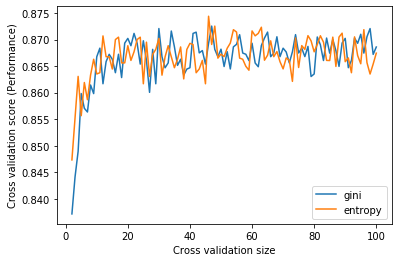

Decision Trees Dataset 1 best score = 0.8743895039439787 at cv = 46(criterion=entropy) in 4 minute(s) and 51 second(s)


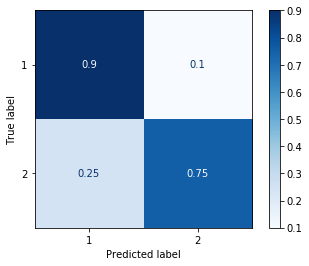

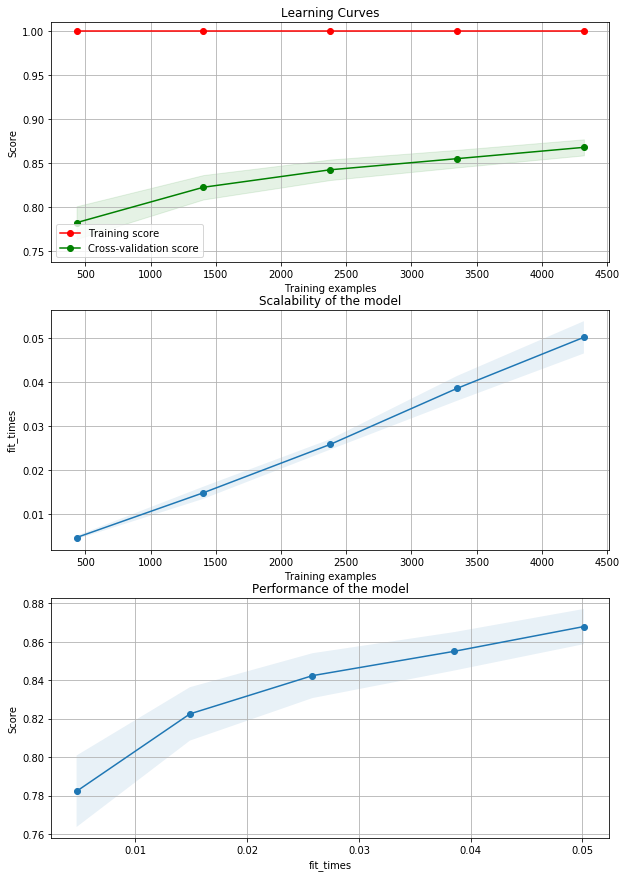

In [44]:
#4 Explore Dataset 1
current_dataset = "Dataset 1"
print(current_dataset + " target names:")
print(dataset1.target_names) 
print(current_dataset + " targets:")
print(np.unique(dataset1.target))
print(current_dataset + " data shape:")
print(X_ds1.shape) 
#print(current_dataset + " description:")
#print(dataset1.DESCR) 
print() 

#4.1 Decision Trees
cv_ds1, criterion_ds1, min_score, clf = decisionTree(X_Train_ds1, y_Train_ds1)
#Maximums found at cv=46 (criterion = entropy) & cv=47 (criterion = gini), 
#but cv=20 (criterion = gini) is sufficient
cv_ds1 = 20
criterion_ds1 = 'gini'
confusionMatrix(X_Train_ds1, X_Test_ds1, y_Train_ds1, y_Test_ds1, clf, 'true')
plot_learning_curve(clf, X_ds1, y_ds1, cv_ds1, min_score)


Exploring Decision Trees with pre-pruning...
2 : 0.7705378477555896
4 : 0.7858017579791773
5 : 0.8105617426181941
6 : 0.8304456818569722
7 : 0.8429424816521591
8 : 0.8515040962621606
9 : 0.8621362433862434
10 : 0.8651433691756273
11 : 0.8669952210274792
13 : 0.8674475166410651
16 : 0.8706861239119303
20 : 0.8718424645844001
Decision Trees Dataset 1 with pre-pruning best score = 0.8718424645844001 at max_depth = 20 in 7 second(s)


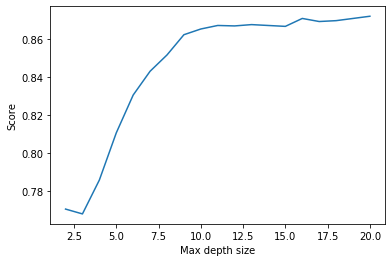

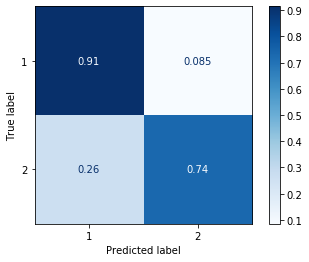

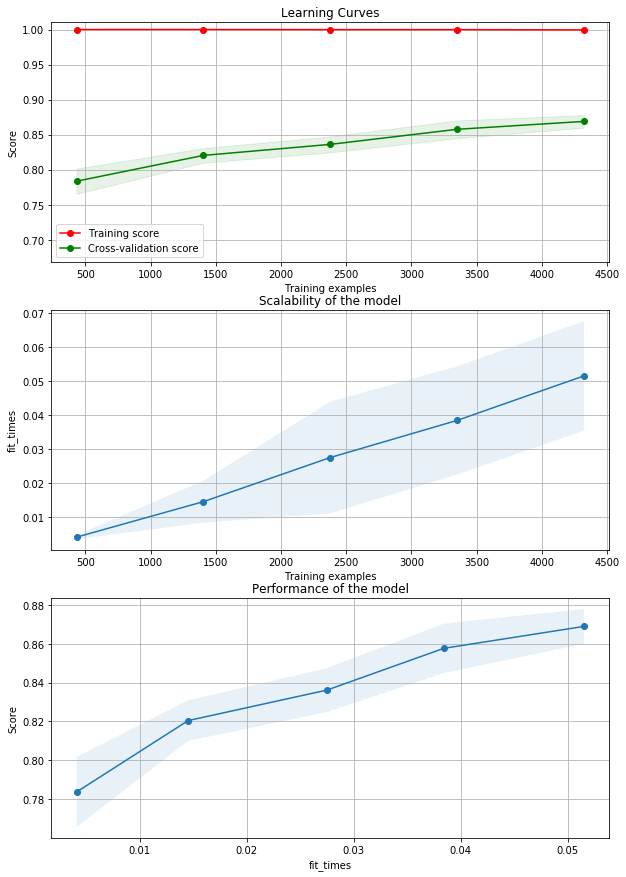

In [20]:
#4.1.1 Decision Tree with pre-pruning
min_score, clf = decisionTreePrePruning(X_Train_ds1, y_Train_ds1, cv_ds1, criterion_ds1)
confusionMatrix(X_Train_ds1, X_Test_ds1, y_Train_ds1, y_Test_ds1, clf, 'true')
plot_learning_curve(clf, X_ds1, y_ds1, cv_ds1, min_score)

Exploring Decision Trees with post-pruning...
0 : 0.8702178272742789
Decision Trees Dataset 1 with post-pruning best score = 0.8702178272742789 at ccp_alpha = 0 in 5 second(s)


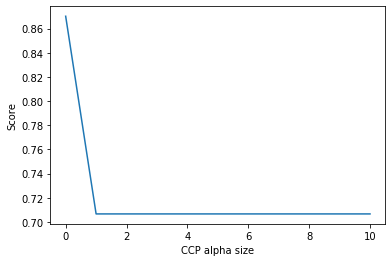

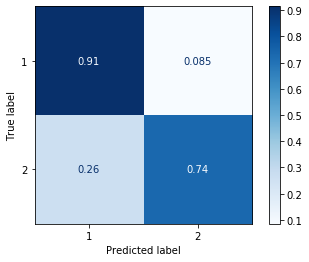

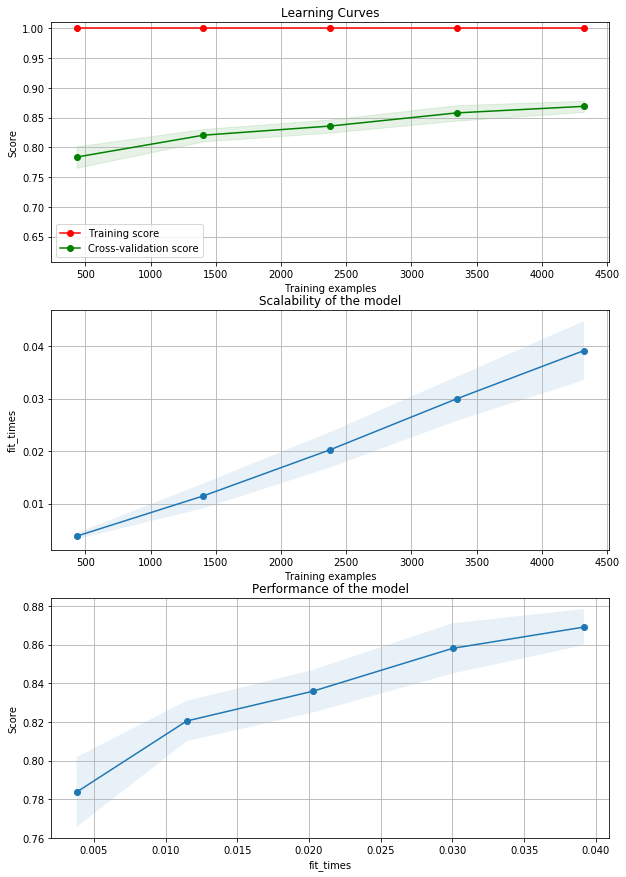

In [21]:
#4.1.2 Decision Tree with post-pruning
min_score, clf = decisionTreePostPruning(X_Train_ds1, y_Train_ds1, cv_ds1, criterion_ds1)
confusionMatrix(X_Train_ds1, X_Test_ds1, y_Train_ds1, y_Test_ds1, clf, 'true')
plot_learning_curve(clf, X_ds1, y_ds1, cv_ds1, min_score)

Exploring Neural Networks...
lbfgs : 0.7816542925413892
sgd (constant) : 0.7066862945895206
sgd (adaptive) : 0.7066862945895206
sgd (invscaling) : 0.4584912101041133
adam : 0.7066862945895206
Neural Network Dataset 1 with best score = 0.7816542925413892 at solver: lbfgs in 13 minute(s) and 26 second(s)

alpha 100000.0 : 0.7066862945895206
alpha 100.0 : 0.7816542925413892
alpha 10.0 : 0.822825994196962
Neural Network Dataset 1 with best score = 0.822825994196962 at alpha order of magnitude: 10.0 in 2 minute(s) and 16 second(s)

(1, 1), activation=identity : 0.7538797149684247
(1, 1), activation=logistic : 0.7788765147636115
(1, 1), activation=tanh : 0.7830357142857143
(2, 1), activation=tanh : 0.7939078767707801
(2, 2), activation=tanh : 0.7941350913125106
(2, 3), activation=relu : 0.795992276839051
(2, 4), activation=tanh : 0.7994644990612733
(2, 4), activation=relu : 0.8017729134664618
(2, 5), activation=relu : 0.8064078767707802
(3, 3), activation=tanh : 0.8084805427547364
(3, 5), ac

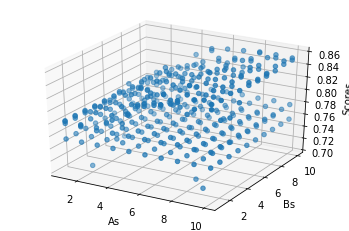

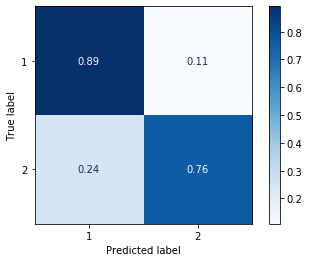

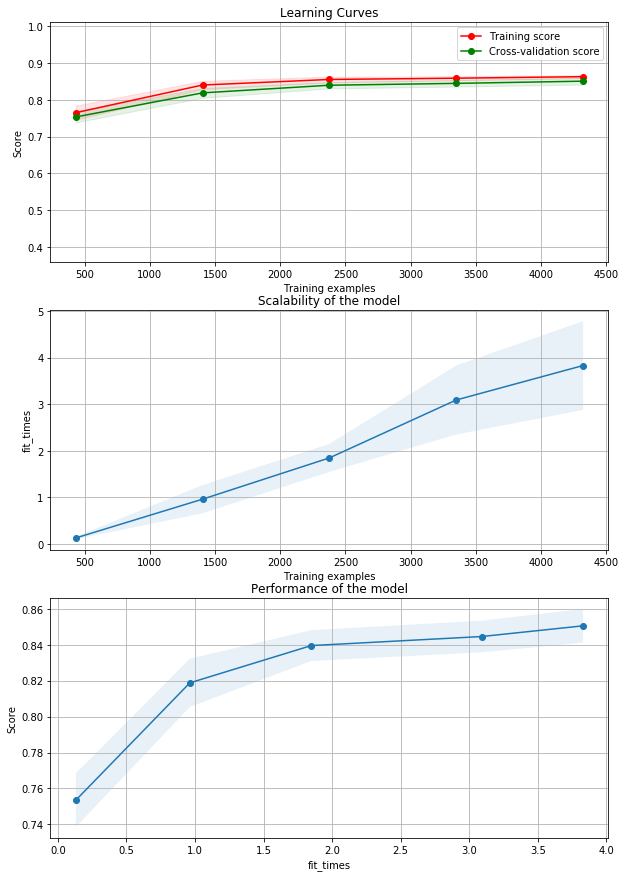

In [22]:
#4.2 Neural Networks
min_score, clf = neuralNetworks(X_Train_ds1, y_Train_ds1, cv_ds1)
confusionMatrix(X_Train_ds1, X_Test_ds1, y_Train_ds1, y_Test_ds1, clf, 'true')
plot_learning_curve(clf, X_ds1, y_ds1, cv_ds1, min_score)

Exploring Boosting...
n_estimators = 1 : 0.7548088410991637
n_estimators = 2 : 0.7774716248506571
n_estimators = 4 : 0.7795538914490528
n_estimators = 5 : 0.7841824543437448
n_estimators = 6 : 0.7871949138078171
n_estimators = 7 : 0.8015339648404165
n_estimators = 12 : 0.8050008533879502
n_estimators = 13 : 0.8059267793138762
n_estimators = 14 : 0.8098608977641236
n_estimators = 15 : 0.8135646014678273
n_estimators = 21 : 0.8137982164191842
n_estimators = 22 : 0.8140211640211641
n_estimators = 23 : 0.8165695937873358
n_estimators = 26 : 0.819346304830176
n_estimators = 28 : 0.8193505717699265
n_estimators = 35 : 0.8195799197815328
n_estimators = 44 : 0.819815668202765
n_estimators = 45 : 0.8202775644307903
n_estimators = 51 : 0.8211981566820276
n_estimators = 53 : 0.8221240826079533
n_estimators = 61 : 0.823047875064004
n_estimators = 63 : 0.823510838026967
Boosting Dataset 1 with best score = 0.823510838026967 at n_estimators: 63 in 15 minute(s) and 47 second(s)


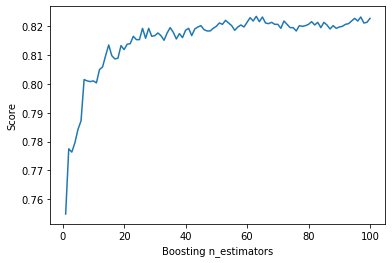

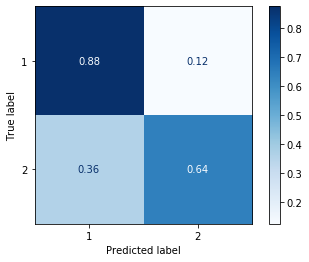

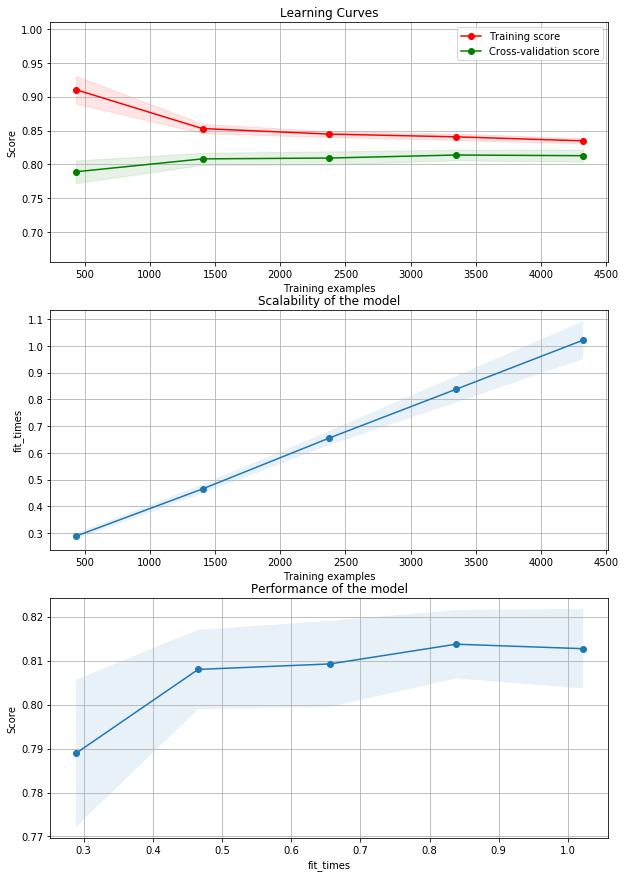

In [23]:
#4.3 Boosting
min_score, clf = boosting(X_Train_ds1, y_Train_ds1, cv_ds1)
confusionMatrix(X_Train_ds1, X_Test_ds1, y_Train_ds1, y_Test_ds1, clf, 'true')
plot_learning_curve(clf, X_ds1, y_ds1, cv_ds1, min_score)
#Highest scoring n_estimators = 63, but n_estimators = 21 should be sufficient

Exploring Support Vector Machines...
SVC score: 0.8413295784263527
NuSVC score: 0.8040909284860897
LinearSVC score: 0.7545773596176822
kernel: linear, shrinking: True, probability: True, decision_function_shape: ovo, score: 0.7786471667520055
kernel: rbf, shrinking: True, probability: True, decision_function_shape: ovo, gamma: scale, score: 0.8413295784263527
Support Vector Machines Dataset 1 with best score = 0.8413295784263527 at SVM: SVC in 16 minute(s) and 13 second(s)


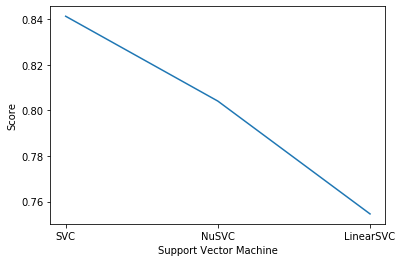

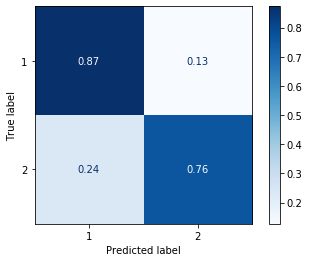

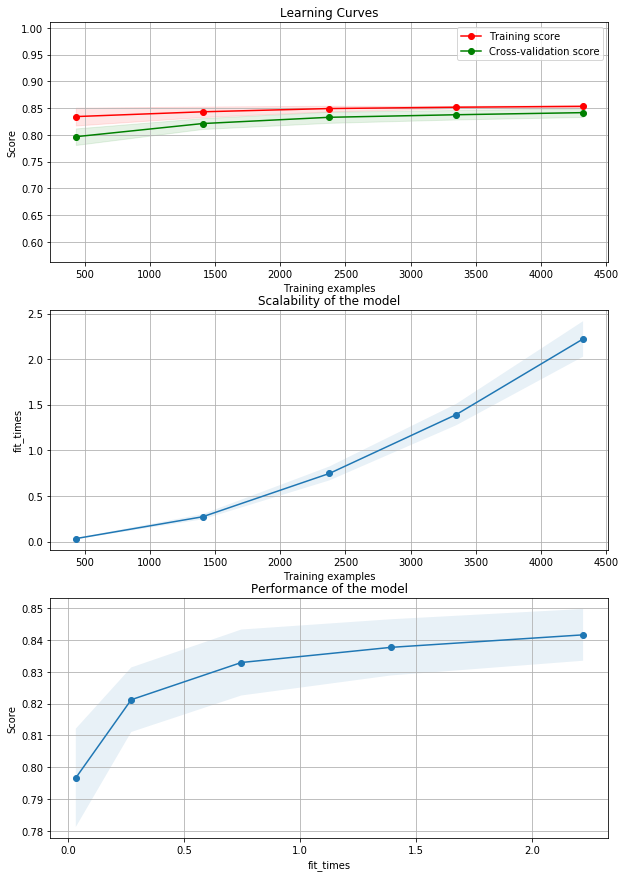

In [24]:
#4.4 Support Vector Machines
min_score, clf = supportVectorMachines(X_Train_ds1, y_Train_ds1, cv_ds1)
confusionMatrix(X_Train_ds1, X_Test_ds1, y_Train_ds1, y_Test_ds1, clf, 'true')
plot_learning_curve(clf, X_ds1, y_ds1, cv_ds1, min_score)

Exploring K-Nearest Neighbors...
k = 1 : 0.8982185526540365
K-Nearest Neighbor Dataset 1 with best score:0.8982185526540365 with k = 1 in 13 second(s)


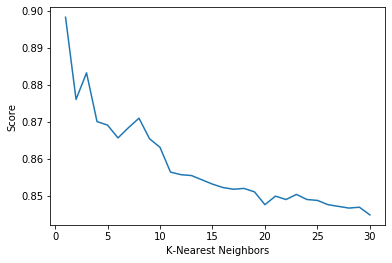

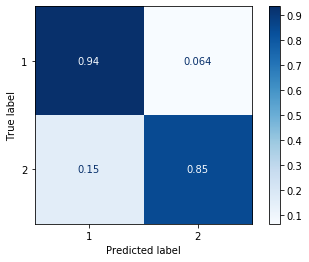

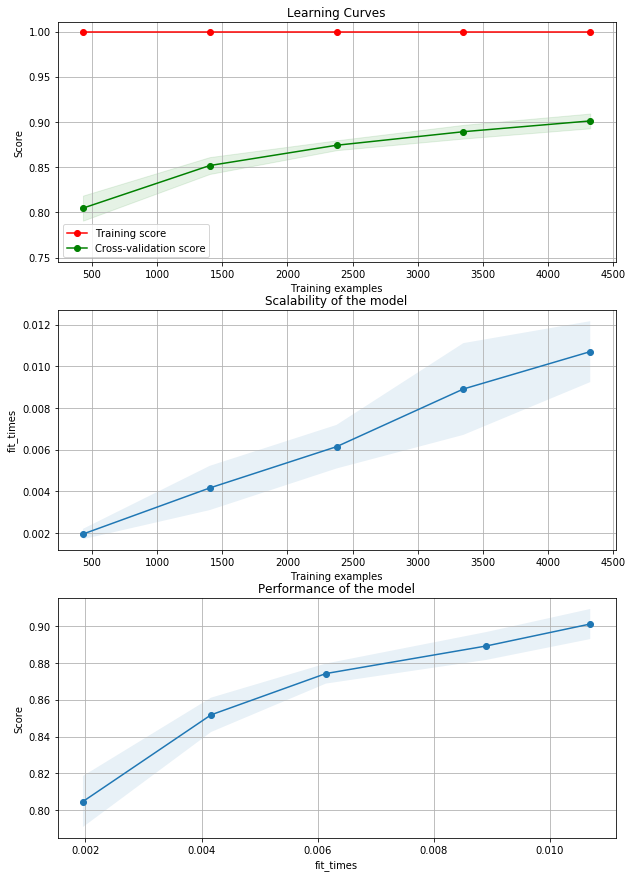

In [25]:
#4.5 K-Nearest Neighbors
min_score, clf = kNearestNeighbors(X_Train_ds1, y_Train_ds1, cv_ds1)
confusionMatrix(X_Train_ds1, X_Test_ds1, y_Train_ds1, y_Test_ds1, clf, 'true')
plot_learning_curve(clf, X_ds1, y_ds1, cv_ds1, min_score)

Dataset 2 target names:
['class']
Dataset 2 targets:
['bad' 'good']
Dataset 2 data shape:
(1000, 20)

Exploring Decision Trees with no pruning...
cv=2, criterion=gini : 0.66875
cv=3, criterion=gini : 0.6999755944167535
cv=4, criterion=gini : 0.725
cv=30, criterion=entropy : 0.7284425451092118


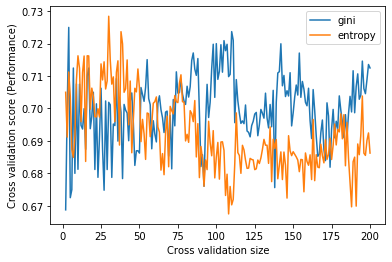

Decision Trees Dataset 2 best score = 0.7284425451092118 at cv = 30(criterion=entropy) in 3 minute(s) and 46 second(s)


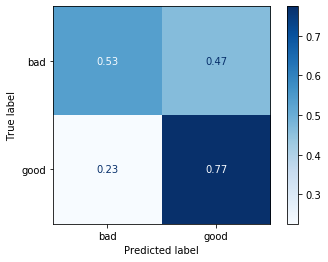

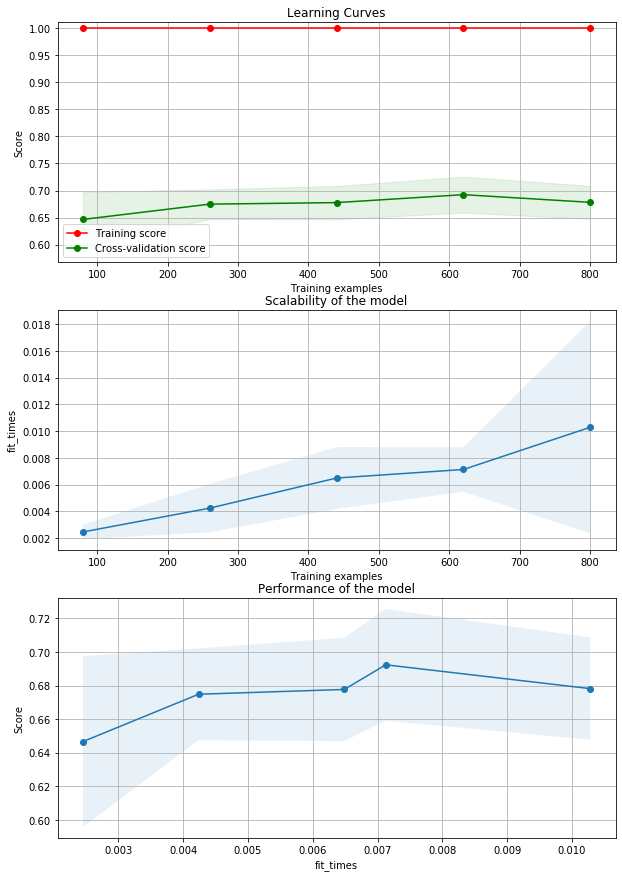

In [45]:
#5 Explore Dataset 2
current_dataset = "Dataset 2"
print(current_dataset + " target names:")
print(dataset2.target_names) 
print(current_dataset + " targets:")
print(np.unique(dataset2.target))
print(current_dataset + " data shape:")
print(X_ds2.shape) 
#print(current_dataset + " description:")
#print(dataset2.DESCR) 
print() 

#5.1 Decision Trees
cv_ds2, criterion_ds2, min_score, clf = decisionTree(X_Train_ds2, y_Train_ds2, cv_max=200)
#Even when cv_max is increased from default 100 to 200, 
#no early cv value stands out as sufficient before what the function finds, so leaving them alone
confusionMatrix(X_Train_ds2, X_Test_ds2, y_Train_ds2, y_Test_ds2, clf, 'true')
plot_learning_curve(clf, X_ds2, y_ds2, cv_ds2, min_score)


Exploring Decision Trees with pre-pruning...
2 : 0.7187559354226021
3 : 0.7386039886039886
Decision Trees Dataset 2 with pre-pruning best score = 0.7386039886039886 at max_depth = 3 in 2 second(s)


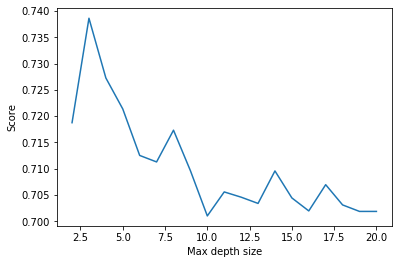

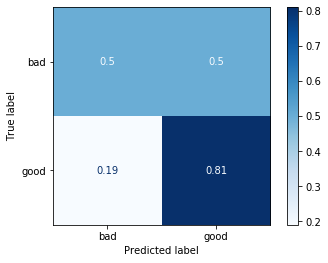

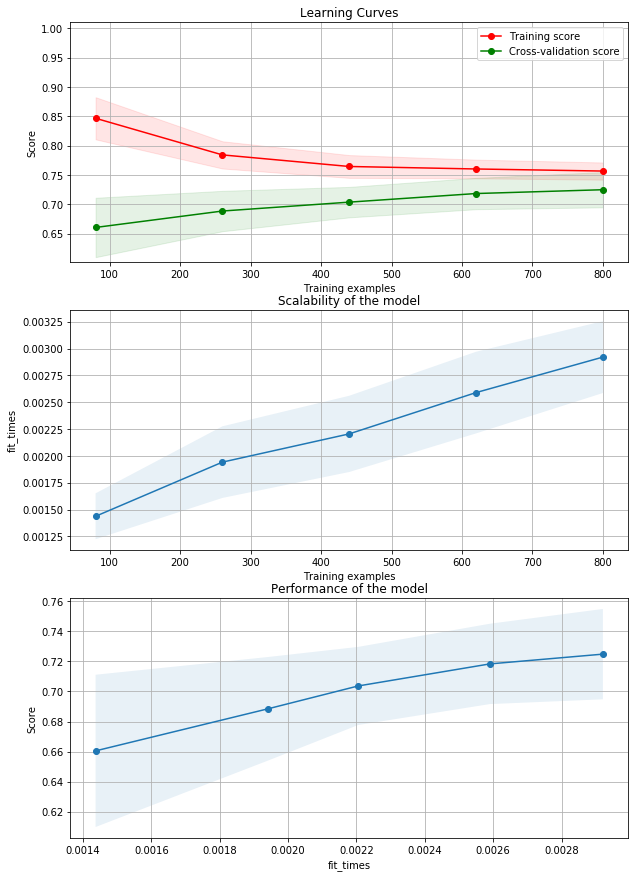

In [27]:
#5.1.1 Decision Tree with pre-pruning
min_score, clf = decisionTreePrePruning(X_Train_ds2, y_Train_ds2, cv_ds2, criterion_ds2)
confusionMatrix(X_Train_ds2, X_Test_ds2, y_Train_ds2, y_Test_ds2, clf, 'true')
plot_learning_curve(clf, X_ds2, y_ds2, cv_ds2, min_score)

Exploring Decision Trees with post-pruning...
0 : 0.7018993352326685
Decision Trees Dataset 2 with post-pruning best score = 0.7018993352326685 at ccp_alpha = 0 in 1 second(s)


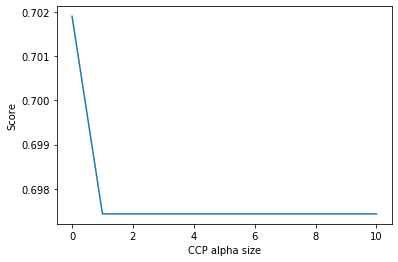

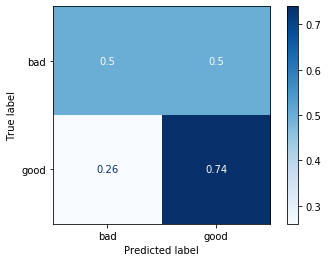

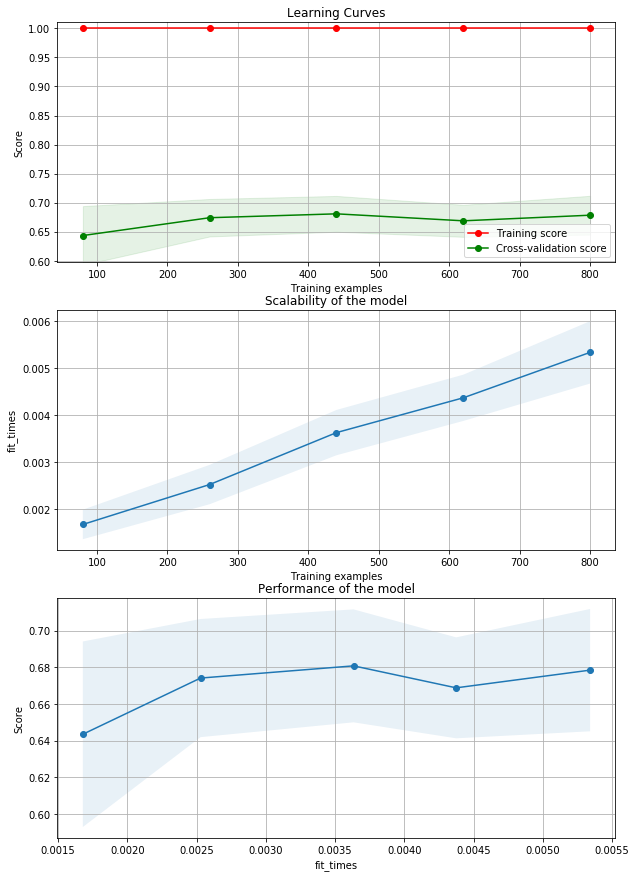

In [28]:
#5.1.2 Decision Tree with post-pruning 
min_score, clf = decisionTreePostPruning(X_Train_ds2, y_Train_ds2, cv_ds2, criterion_ds2)
confusionMatrix(X_Train_ds2, X_Test_ds2, y_Train_ds2, y_Test_ds2, clf, 'true')
plot_learning_curve(clf, X_ds2, y_ds2, cv_ds2, min_score)

Exploring Neural Networks...
lbfgs : 0.7087844254510922
sgd (constant) : 0.6974358974358977
sgd (adaptive) : 0.6974358974358977
sgd (invscaling) : 0.6974358974358977
Neural Network Dataset 2 with best score = 0.7087844254510922 at solver: lbfgs in 17 second(s)

alpha 100000.0 : 0.6974358974358977
alpha 1000.0 : 0.7024691358024693
alpha 100.0 : 0.7087844254510922
Neural Network Dataset 2 with best score = 0.7087844254510922 at alpha order of magnitude: 100.0 in 19 second(s)

(1, 1), activation=logistic : 0.6974358974358977
(1, 4), activation=identity : 0.7037511870845204
(1, 4), activation=relu : 0.7075023741690409
(1, 5), activation=relu : 0.7113010446343779
(5, 7), activation=relu : 0.711301044634378
(7, 6), activation=relu : 0.7125830959164292
Neural Network Dataset 2 with best score = 0.7125830959164292 at hidden layer: (7, 6) with activation = relu in 14 minute(s) and 43 second(s)


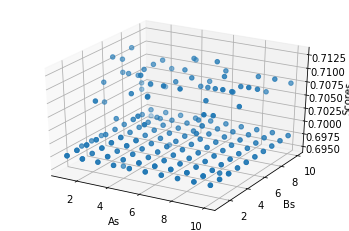

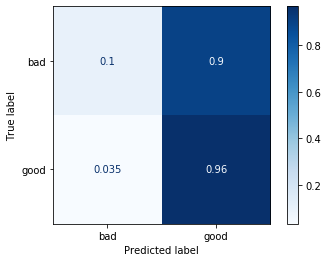

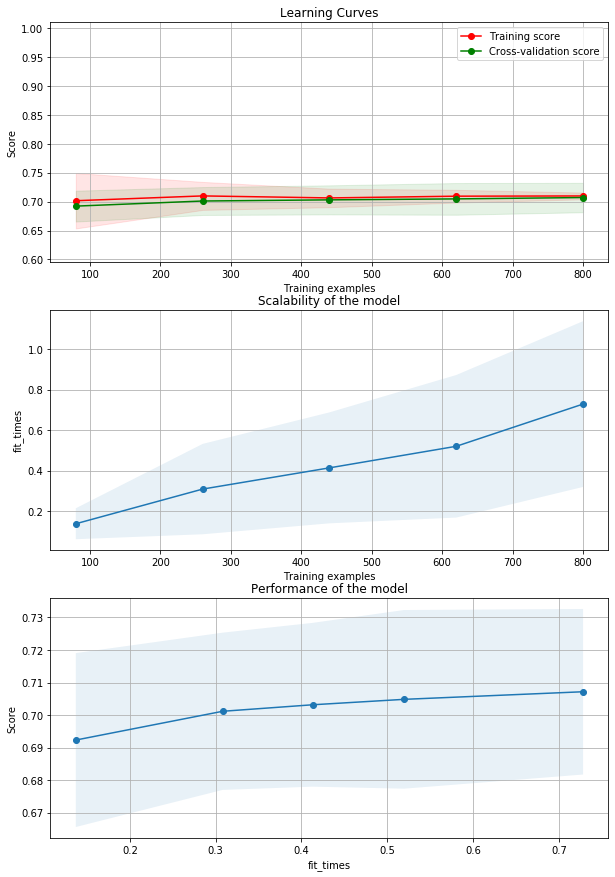

In [29]:
#5.2 Neural Networks
min_score, clf = neuralNetworks(X_Train_ds2, y_Train_ds2, cv_ds2)
confusionMatrix(X_Train_ds2, X_Test_ds2, y_Train_ds2, y_Test_ds2, clf, 'true')
plot_learning_curve(clf, X_ds2, y_ds2, cv_ds2, min_score)

Exploring Boosting...
n_estimators = 1 : 0.6974358974358977
n_estimators = 3 : 0.7248812915479583
n_estimators = 5 : 0.7299145299145301
n_estimators = 8 : 0.7400284900284899
n_estimators = 9 : 0.7449667616334282
n_estimators = 10 : 0.7498575498575498
n_estimators = 14 : 0.7537037037037037
n_estimators = 19 : 0.7573599240265906
n_estimators = 23 : 0.7574074074074074
n_estimators = 31 : 0.7586894586894587
Boosting Dataset 2 with best score = 0.7586894586894587 at n_estimators: 31 in 8 minute(s) and 24 second(s)


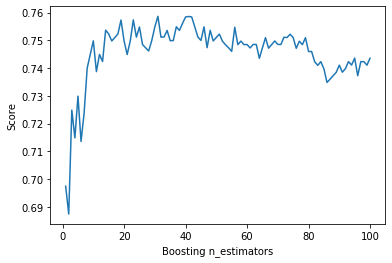

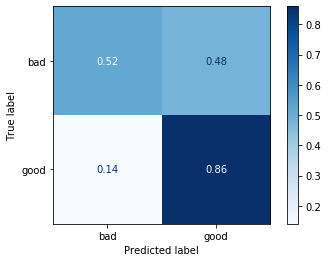

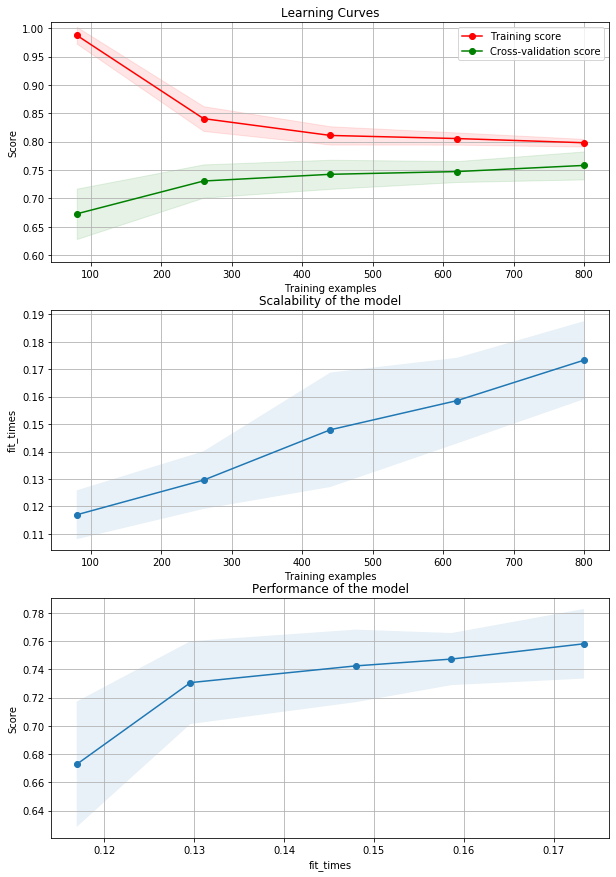

In [30]:
#5.3 Boosting
min_score, clf = boosting(X_Train_ds2, y_Train_ds2, cv_ds2)
confusionMatrix(X_Train_ds2, X_Test_ds2, y_Train_ds2, y_Test_ds2, clf, 'true')
plot_learning_curve(clf, X_ds2, y_ds2, cv_ds2, min_score)

Exploring Support Vector Machines...
SVC score: 0.7075498575498576
NuSVC score: 0.5999050332383666
kernel: poly, shrinking: True, probability: True, decision_function_shape: ovo, gamma: scale, score: 0.7025166191832858
kernel: rbf, shrinking: True, probability: True, decision_function_shape: ovo, gamma: scale, score: 0.7075498575498576
Support Vector Machines Dataset 2 with best score = 0.7075498575498576 at SVM: SVC in 1 minute(s) and 35 second(s)


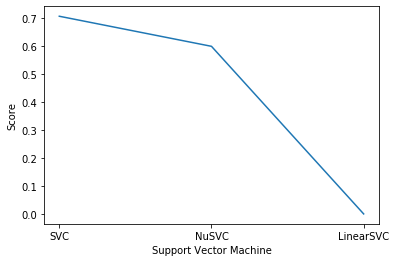

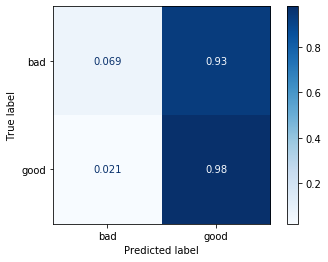

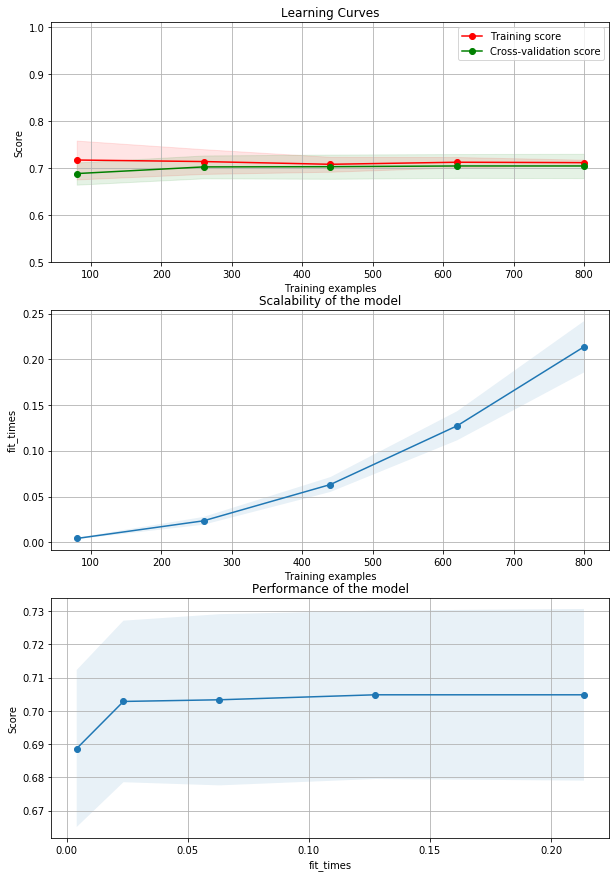

In [31]:
#5.4 Support Vector Machines
min_score, clf = supportVectorMachines(X_Train_ds2, y_Train_ds2, cv_ds2, is_dataset_2=True)
confusionMatrix(X_Train_ds2, X_Test_ds2, y_Train_ds2, y_Test_ds2, clf, 'true')
plot_learning_curve(clf, X_ds2, y_ds2, cv_ds2, min_score)

Exploring K-Nearest Neighbors...
k = 1 : 0.6311490978157646
k = 5 : 0.6699905033238367
k = 7 : 0.6702279202279201
k = 9 : 0.6801994301994303
k = 11 : 0.6851851851851852
k = 14 : 0.6862773029439696
k = 15 : 0.6938746438746438
k = 21 : 0.7013770180436848
K-Nearest Neighbor Dataset 2 with best score:0.7013770180436848 with k = 21 in 4 second(s)


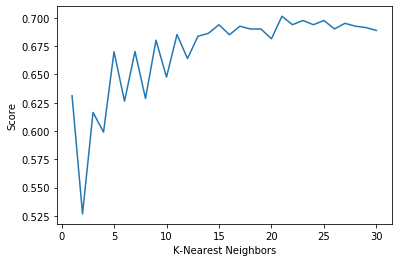

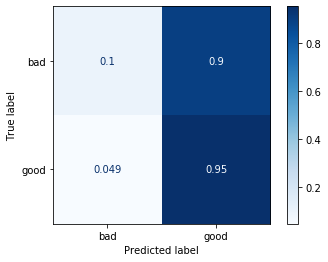

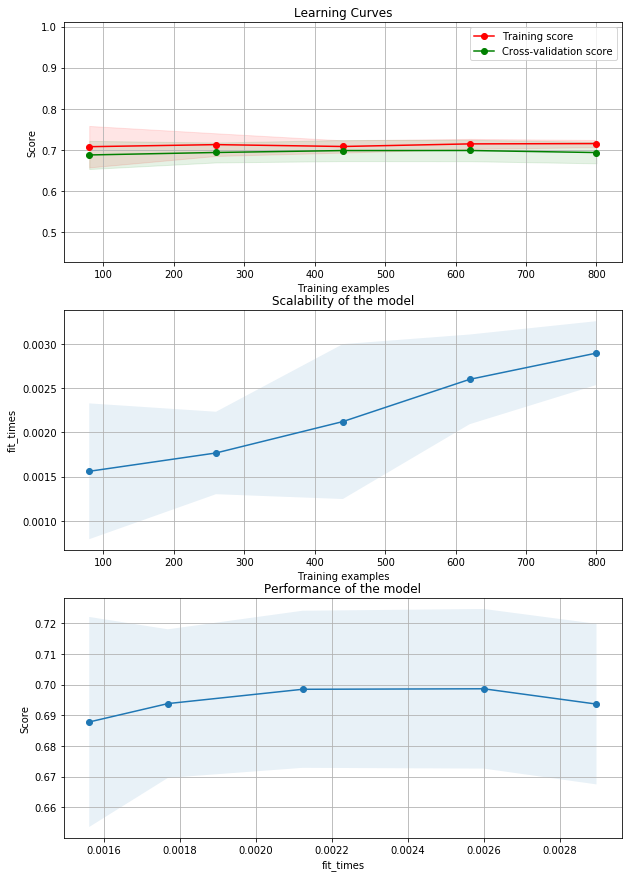

In [32]:
#5.5 K-Nearest Neighbors
min_score, clf = kNearestNeighbors(X_Train_ds2, y_Train_ds2, cv_ds2)
confusionMatrix(X_Train_ds2, X_Test_ds2, y_Train_ds2, y_Test_ds2, clf, 'true')
plot_learning_curve(clf, X_ds2, y_ds2, cv_ds2, min_score)